# Import

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2
from collections import namedtuple

import torch
from torch import nn, optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler, SGD
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torchsummary import summary

sns.set_style('darkgrid')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper Parameters

In [2]:
BATCH_SIZE = 512
MOMENTUM = 0.9
LEARNING_RATE = 0.4
WEIGHT_DECAY =  0.000125
EPOCHS = 24

# Transformation

In [3]:
my_transform = {
    'train': transforms.Compose([
        transforms.Pad(4, padding_mode='reflect'),
        transforms.RandomCrop(size=32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.4), ratio=(0.3, 3.3), value=(0.4914, 0.4822, 0.4465)),
        transforms.Normalize([0.4914, 0.4822, 0.4465],
                             [0.2023, 0.1994, 0.2010])
    ]),
    
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465],
                             [0.2023, 0.1994, 0.2010])
    ])
}

# Prepare Dataset and Loader

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True, 
                            download=True, transform=my_transform['train'])
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, 
                         shuffle=False, num_workers=4)

testset = datasets.CIFAR10(root='./data', train=False, 
                           download=True, transform=my_transform['test'])
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, 
                        shuffle=False, num_workers=4)

# for Visualisation with small batch
train_visualize_loader = DataLoader(trainset, batch_size=10, 
                         shuffle=True, num_workers=4)
test_visualize_loader = DataLoader(testset, batch_size=10, 
                         shuffle=True, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def check_shape(ds_loader, name):
    examples = enumerate(ds_loader)
    b_id, example_data = next(examples)
    
    print('[{}] batch: {}, Shape: {} '.format(name, b_id, example_data[0].shape))

check_shape(train_loader, 'train')
check_shape(test_loader, 'test')

[train] batch: 0, Shape: torch.Size([512, 3, 32, 32]) 
[test] batch: 0, Shape: torch.Size([512, 3, 32, 32]) 


# Batch Visualization

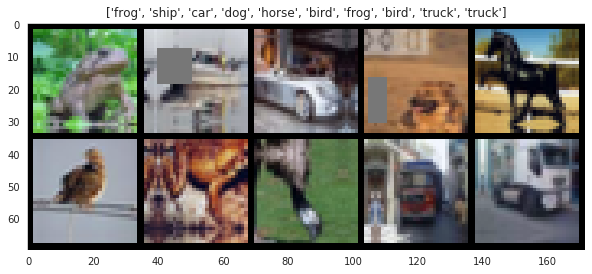

In [6]:
def imshow(img, title=''):
    
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.grid(False)
    plt.show()

for i, data in enumerate(train_visualize_loader):
    img, label = data
    imshow(make_grid(img, nrow=5, normalize=True), title=[classes[label[j]] for j in range(img.shape[0])])
    break

# Model

In [7]:
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), x.size(1))
    

def batch_norm(num_channels, bn_bias_init=None, bn_bias_freeze=False,
               bn_weight_init=None, bn_weight_freeze=False):
    m = nn.BatchNorm2d(num_channels)
    if bn_bias_init is not None:
        m.bias.data.fill_(bn_bias_init)
    if bn_bias_freeze:
        m.bias.requires_grad = False
    if bn_weight_init is not None:
        m.weight.data.fill_(bn_weight_init)
    if bn_weight_freeze:
        m.weight.requires_grad = False

    return m


def seq_conv_bn(in_channels, out_channels, conv_kwargs, bn_kwargs):
    if "padding" not in conv_kwargs:
        conv_kwargs["padding"] = 1
    if "stride" not in conv_kwargs:
        conv_kwargs["stride"] = 1
    if "bias" not in conv_kwargs:
        conv_kwargs["bias"] = False
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels,
                  kernel_size=3, **conv_kwargs),
        batch_norm(out_channels, **bn_kwargs),
        nn.ReLU(inplace=True)
    )


def conv_bn_elu(in_channels, out_channels, conv_kwargs, bn_kwargs, alpha=1.0):
    if "padding" not in conv_kwargs:
        conv_kwargs["padding"] = 1
    if "stride" not in conv_kwargs:
        conv_kwargs["stride"] = 1
    if "bias" not in conv_kwargs:
        conv_kwargs["bias"] = False
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels,
                  kernel_size=3, **conv_kwargs),
        batch_norm(out_channels, **bn_kwargs),
        nn.ELU(alpha=alpha, inplace=True)
    )


class FastResnet(nn.Module):

    def __init__(self, conv_kwargs=None, bn_kwargs=None,
                 conv_bn_fn=seq_conv_bn,
                 final_weight=0.125):
        super(FastResnet, self).__init__()

        conv_kwargs = {} if conv_kwargs is None else conv_kwargs
        bn_kwargs = {} if bn_kwargs is None else bn_kwargs

        self.prep = conv_bn_fn(3, 64, conv_kwargs, bn_kwargs)

        self.layer1 = nn.Sequential(
            conv_bn_fn(64, 128, conv_kwargs, bn_kwargs),
            nn.MaxPool2d(kernel_size=2),
            IdentityResBlock(128, 128, conv_kwargs, bn_kwargs, conv_bn_fn=conv_bn_fn)
        )

        self.layer2 = nn.Sequential(
            conv_bn_fn(128, 256, conv_kwargs, bn_kwargs),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer3 = nn.Sequential(
            conv_bn_fn(256, 512, conv_kwargs, bn_kwargs),
            nn.MaxPool2d(kernel_size=2),
            IdentityResBlock(512, 512, conv_kwargs, bn_kwargs, conv_bn_fn=conv_bn_fn)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveMaxPool2d(1),
            Flatten(),
            nn.Linear(512, 10, bias=False)
        )

        if final_weight == "auto":
            self.final_weight = torch.nn.Parameter(torch.Tensor([0.125]))
        else:
            self.final_weight = final_weight

    def forward(self, x):

        x = self.prep(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.classifier(x)
        x = x * self.final_weight
        return x


class IdentityResBlock(nn.Module):

    def __init__(self, in_channels, out_channels, conv_kwargs, bn_kwargs,
                 conv_bn_fn=seq_conv_bn):
        super(IdentityResBlock, self).__init__()
        self.conv1 = conv_bn_fn(in_channels, out_channels, conv_kwargs, bn_kwargs)
        self.conv2 = conv_bn_fn(out_channels, out_channels, conv_kwargs, bn_kwargs)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)
        return x + residual

In [8]:
len(test_loader)

20

In [9]:
model = FastResnet().to(device)

optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,
                nesterov=True)

criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=EPOCHS*len(train_loader), 
                                    epochs=EPOCHS, anneal_strategy='cos',
                                    base_momentum=0.85, max_momentum=0.95, div_factor=5)

In [10]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
 IdentityResBlock-14          [-1, 128,

# Training & Validation

In [11]:
%%time
import time
import copy

# epochs = 25
train_losses, test_losses = [], []
train_acc, test_acc = [], []
start_time = time.time()
# best_val_loss = float('Inf')

for e in range(1, EPOCHS+1):
    epoch_start_time = time.time()
    running_loss = 0
    
    # TRAINING PART
    accuracy = 0
    model.train()
    print('Epoch:', e,'LR:', scheduler.get_lr())
    for images, label in train_loader:
        # load data to GPU
        images = images.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        
        # Compute the accuracy
        ret, predictions = torch.max(output.data, 1)
        correct_counts = predictions.eq(label.data.view_as(predictions))
         
        # Convert correct_counts to float and then compute the mean
        accuracy += torch.mean(correct_counts.type(torch.FloatTensor))
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        scheduler.step()
        
        running_loss += loss.item()
        del images, label, output, ret, predictions
    
    # record training loss and error, then evaluate using validation data
    train_losses.append(running_loss/len(train_loader))
    train_acc.append(accuracy/len(train_loader))
    
    # VALIDATION PART
    test_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for images, label in test_loader:
            images = images.to(device)
            label = label.to(device)
            output = model(images)
            
            # Compute the accuracy
            ret, predictions = torch.max(output.data, 1)
            correct_counts = predictions.eq(label.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            accuracy += torch.mean(correct_counts.type(torch.FloatTensor))
        
            test_loss += criterion(output, label)
            
            del images, label, output, ret, predictions

    test_losses.append(test_loss/len(test_loader))
    test_acc.append(accuracy/len(test_loader))

    print("Epoch: {}/{} \t".format(e, EPOCHS),
          "Time: {:.2f}s \t".format(time.time()-epoch_start_time),
          "Training Loss: {:.4f} \t".format(train_losses[-1]),
          "Training Accu: {:.4f} \t".format(train_acc[-1]),
          "Val Loss: {:.4f} \t".format(test_losses[-1]),
          "Val Accu: {:.4f}".format(test_acc[-1]))
        
best_model_wts = copy.deepcopy(model.state_dict())
model.load_state_dict(best_model_wts)

Epoch: 1 LR: [0.08000000000000002]
Epoch: 1/24 	 Time: 17.30s 	 Training Loss: 1.3928 	 Training Accu: 0.4924 	 Val Loss: 1.0925 	 Val Accu: 0.6142
Epoch: 2 LR: [0.0950326557343032]
Epoch: 2/24 	 Time: 17.39s 	 Training Loss: 0.8961 	 Training Accu: 0.6804 	 Val Loss: 0.7232 	 Val Accu: 0.7455
Epoch: 3 LR: [0.13730586370688685]
Epoch: 3/24 	 Time: 17.80s 	 Training Loss: 0.7275 	 Training Accu: 0.7445 	 Val Loss: 0.6681 	 Val Accu: 0.7663
Epoch: 4 LR: [0.19887614163979533]
Epoch: 4/24 	 Time: 17.49s 	 Training Loss: 0.6529 	 Training Accu: 0.7716 	 Val Loss: 0.8195 	 Val Accu: 0.7285
Epoch: 5 LR: [0.26817392963764386]
Epoch: 5/24 	 Time: 17.55s 	 Training Loss: 0.5927 	 Training Accu: 0.7913 	 Val Loss: 0.5780 	 Val Accu: 0.8009
Epoch: 6 LR: [0.3321776053239276]
Epoch: 6/24 	 Time: 18.55s 	 Training Loss: 0.5332 	 Training Accu: 0.8136 	 Val Loss: 0.5245 	 Val Accu: 0.8177
Epoch: 7 LR: [0.3788603534196228]
Epoch: 7/24 	 Time: 19.75s 	 Training Loss: 0.4884 	 Training Accu: 0.8297 	 Val

<All keys matched successfully>

# Plot Accuracy & Loss Graph

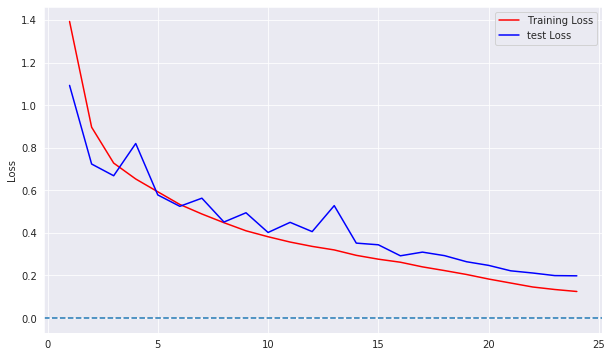

In [13]:
# Training Loss & Validation Loss
plt.figure(figsize=(10,6))

plt.ylabel('Loss')
plt.plot(range(1, EPOCHS + 1), train_losses[:EPOCHS+1], 'r', label='Training Loss')
plt.plot(range(1, EPOCHS + 1), test_losses[:EPOCHS+1], 'b', label='test Loss')
plt.axhline(y=0, linestyle='--')
plt.legend()

plt.show()

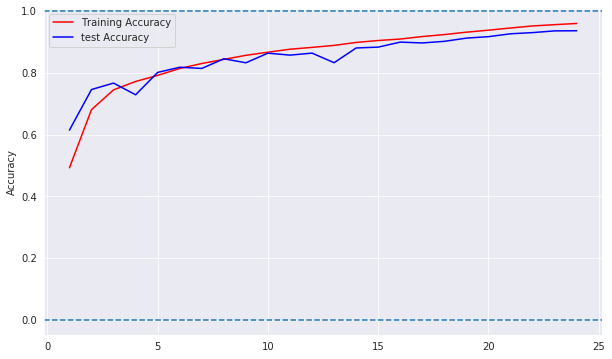

In [14]:
# Training Accuracy & Validation Accuracy
plt.figure(figsize=(10,6))

plt.ylabel('Accuracy')
plt.plot(range(1, EPOCHS + 1), train_acc[:EPOCHS+1], 'r', label='Training Accuracy')
plt.plot(range(1, EPOCHS + 1), test_acc[:EPOCHS+1], 'b', label='test Accuracy')
plt.grid(linestyle='-')
plt.axhline(y=0, linestyle='--')
plt.axhline(y=1, linestyle='--')
plt.legend()

plt.show()

# Prediction

In [15]:
%%time

# Prediction
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('- - '*17)
print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
print('- - '*17)


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Accuracy of the network on the 10000 test images: 93.51 %
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
CPU times: user 752 ms, sys: 309 ms, total: 1.06 s
Wall time: 1.17 s


# Test Visualization

Truth:    car   dog plane  ship  deer  ship  ship  deer   cat  frog


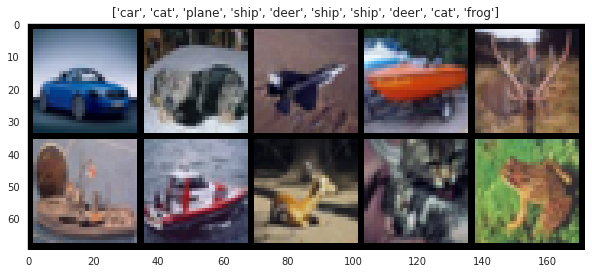

In [16]:
def imshow(img, title=''):
    
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.grid(False)
    plt.show()

for i, data in enumerate(test_visualize_loader):
    img, label = data
    img = img.to(device)
    outputs = model(img)
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.cpu().numpy()
    img = img.cpu()
    print('Truth: ', ' '.join('%5s' % classes[label[j]] for j in range(img.shape[0])))
    imshow(make_grid(img, nrow=5, normalize=True), title=[classes[predicted[j]] for j in range(img.shape[0])])
    break

# Freeup memory

In [17]:
torch.cuda.empty_cache()

torch.save(model.state_dict(), 'CIFAR_10_Super_Convergence.pth')